<a href="https://colab.research.google.com/github/Chonna86/Python_projects/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    return self.out_layer(x, activation=1)

In [8]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Отримуємо індекси класів з передбачених ймовірностей
    predicted_class = tf.argmax(y_pred, axis=1)
    # Перетворюємо тип даних міток класів на int64
    y_true = tf.cast(y_true, tf.int64)
    # Порівнюємо передбачені класи з істинними класами
    correct_predictions = tf.equal(predicted_class, y_true)
    # Обчислюємо середню точність
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [9]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  # Обчислення градієнтів
  gradients = g.gradient(loss, neural_net.trainable_variables)

  # Оновлення параметрів
  optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

In [10]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")

Step 100, Loss: 589.90185546875, Accuracy: 0.1171875
Step 200, Loss: 591.8349609375, Accuracy: 0.09375
Step 300, Loss: 586.4737548828125, Accuracy: 0.13671875
Step 400, Loss: 585.9224853515625, Accuracy: 0.1171875
Step 500, Loss: 578.5369873046875, Accuracy: 0.1796875
Step 600, Loss: 575.0128784179688, Accuracy: 0.2109375
Step 700, Loss: 571.2967529296875, Accuracy: 0.2265625
Step 800, Loss: 547.2101440429688, Accuracy: 0.24609375
Step 900, Loss: 538.65673828125, Accuracy: 0.2734375
Step 1000, Loss: 534.4616088867188, Accuracy: 0.23828125
Step 1100, Loss: 519.2900390625, Accuracy: 0.29296875
Step 1200, Loss: 509.87469482421875, Accuracy: 0.29296875
Step 1300, Loss: 498.3265380859375, Accuracy: 0.296875
Step 1400, Loss: 491.70050048828125, Accuracy: 0.36328125
Step 1500, Loss: 474.3390808105469, Accuracy: 0.2890625
Step 1600, Loss: 464.1982421875, Accuracy: 0.28515625
Step 1700, Loss: 472.4534912109375, Accuracy: 0.2578125
Step 1800, Loss: 427.2283935546875, Accuracy: 0.33984375
Step 19

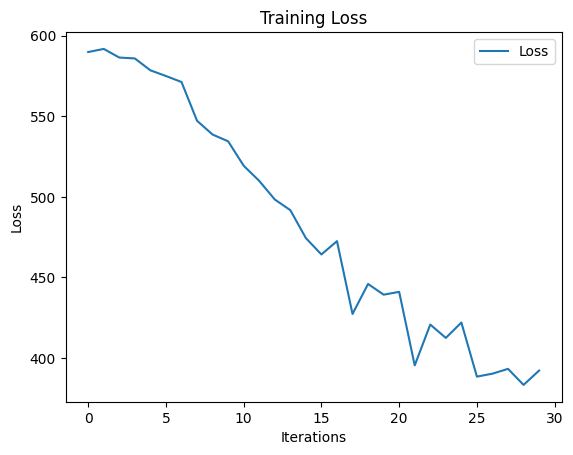

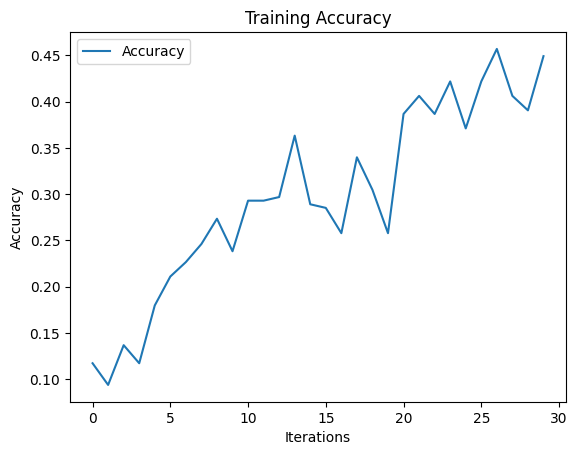

In [11]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()



In [12]:
# Обчисліть точність навченої нейромережі
final_loss = loss_history[-1]
print("Final loss:", final_loss)

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_loss = cross_entropy(test_pred, y_test)
test_accuracy = accuracy(test_pred, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Final loss: tf.Tensor(392.0924, shape=(), dtype=float32)
Test Loss: tf.Tensor(15239.082, shape=(), dtype=float32)
Test Accuracy: tf.Tensor(0.4152, shape=(), dtype=float32)


In [13]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Виведення метрик якості для кожного класу
from sklearn.metrics import classification_report
y_pred_labels = tf.argmax(test_pred, axis=1)
print(classification_report(y_test, y_pred_labels))




              precision    recall  f1-score   support

           0       0.59      0.90      0.71       980
           1       0.49      0.21      0.30      1135
           2       0.55      0.62      0.58      1032
           3       0.37      0.87      0.52      1010
           4       0.00      0.00      0.00       982
           5       0.25      0.01      0.03       892
           6       0.76      0.55      0.64       958
           7       0.26      0.93      0.41      1028
           8       0.26      0.01      0.02       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.42     10000
   macro avg       0.35      0.41      0.32     10000
weighted avg       0.35      0.42      0.32     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
